In [137]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

CNN In Pytorch  
https://justkode.kr/deep-learning/pytorch-cnn

#Step1. Dataset and Dataloader

In [2]:
import sklearn.datasets

mnist = sklearn.datasets.fetch_openml('mnist_784')

In [148]:
X, y = mnist.data.to_numpy().reshape(-1, 1, 28, 28), mnist.target.to_numpy()

In [149]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5, random_state=13)

In [150]:
X_train.shape, X_val.shape, X_test.shape

((63000, 1, 28, 28), (3500, 1, 28, 28), (3500, 1, 28, 28))

In [151]:
X_train = torch.tensor(X_train, dtype=torch.float) / 255.
X_val = torch.tensor(X_val, dtype=torch.float) / 255.
X_test = torch.tensor(X_test, dtype=torch.float) / 255.

y_train = torch.tensor([int(i) for i in y_train])
y_val = torch.tensor([int(i) for i in y_val])
y_test = torch.tensor([int(i) for i in y_test])

In [152]:
from torch.utils.data import Dataset
class MnistDataset(Dataset):
  def __init__(self, X, y):    
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [153]:
train_dataset = MnistDataset(X_train, y_train)
val_dataset = MnistDataset(X_val, y_val)
test_dataset = MnistDataset(X_test, y_test)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [154]:
# Hyper parameters
learning_rate = 1e-3
batch_size = 64
epochs = 25

In [155]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

In [156]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for i, (X, y) in enumerate(dataloader):
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
      loss, current_count = loss.item(), i * len(X)
      print(f"Loss: {loss:>7f} [{current_count:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, data_name="Test"):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct_count = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct_count += (pred.argmax(axis=1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct_count /= size
  print(f"[{data_name} Error]\nAccuracy: {(100 * correct_count):>0.1f}%, Avg loss: {test_loss:>8}\n")


#Step2. Full connected network for MNIST

In [157]:
class FullConnectedModel(nn.Module):
  def __init__(self):
    super(FullConnectedModel, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10),
    )
  
  def forward(self, x):
    x = self.flatten(x)
    logit = self.linear_relu_stack(x)
    return logit
fc_model = FullConnectedModel()

In [158]:
# Optimizer For FullConnectedModel
fc_optimizer = torch.optim.Adam(fc_model.parameters(), lr=learning_rate)

In [159]:
# Scheduler
fc_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=fc_optimizer,\
                                              lr_lambda=lambda epoch: 0.95 ** epoch) 

Epoch 1 =====================
Loss: 2.302940 [    0/63000]
Loss: 0.365614 [ 6400/63000]
Loss: 0.409906 [12800/63000]
Loss: 0.203014 [19200/63000]
Loss: 0.351136 [25600/63000]
Loss: 0.239426 [32000/63000]
Loss: 0.248865 [38400/63000]
Loss: 0.323841 [44800/63000]
Loss: 0.095165 [51200/63000]
Loss: 0.072956 [57600/63000]
[Validate Error]
Accuracy: 97.1%, Avg loss: 0.0973727139559659

Epoch 2 =====================
Loss: 0.019828 [    0/63000]
Loss: 0.124213 [ 6400/63000]
Loss: 0.169193 [12800/63000]
Loss: 0.075231 [19200/63000]
Loss: 0.176957 [25600/63000]
Loss: 0.103953 [32000/63000]
Loss: 0.176781 [38400/63000]
Loss: 0.132649 [44800/63000]
Loss: 0.054309 [51200/63000]
Loss: 0.039920 [57600/63000]
[Validate Error]
Accuracy: 97.4%, Avg loss: 0.07639743698422205

Epoch 3 =====================
Loss: 0.020571 [    0/63000]
Loss: 0.099954 [ 6400/63000]
Loss: 0.068552 [12800/63000]
Loss: 0.048800 [19200/63000]
Loss: 0.178431 [25600/63000]
Loss: 0.042159 [32000/63000]
Loss: 0.095668 [38400/63000

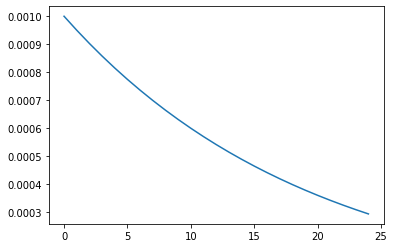

In [160]:
# Running fc_model
lrs = []
for t in range(epochs):
  print(f"Epoch {t+1} =====================")
  lrs.append(fc_optimizer.param_groups[0]['lr'])
  train_loop(train_dataloader, fc_model, loss_fn, fc_optimizer)
  test_loop(val_dataloader, fc_model, loss_fn, data_name="Validate")
  fc_scheduler.step()
plt.plot(lrs)
print("DONE!")

In [161]:
# Test test_dataset
test_loop(test_dataloader, fc_model, loss_fn, data_name="Test")

[Test Error]
Accuracy: 98.3%, Avg loss: 0.136613346361939



In [162]:
from torchsummary import summary

summary(fc_model, (1, 1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 512]         262,656
              ReLU-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.55
Estimated Total Size (MB): 2.58
----------------------------------------------------------------


In [163]:
class CnnModel(nn.Module):
  def __init__(self):
    super(CnnModel, self).__init__()
    self.cnn_layers = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2),
    )
    self.linear_layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64 * 12 * 12, 256),
        nn.Linear(256, 10)
    )
  
  def forward(self, x):
    y = self.cnn_layers(x)
    y = self.linear_layers(y)
    return y
cnn_model = CnnModel()

In [164]:
# Optimizer for CnnModel
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [165]:
# Scheduler for CnnModel
cnn_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=cnn_optimizer,\
                                                  lr_lambda=lambda epoch: 0.95 ** epoch)

[[ CNN model ]]
Epoch 1 =====================
Loss: 0.005120 [    0/63000]
Loss: 0.000076 [ 6400/63000]
Loss: 0.050997 [12800/63000]
Loss: 0.000130 [19200/63000]
Loss: 0.035342 [25600/63000]
Loss: 0.007526 [32000/63000]
Loss: 0.004797 [38400/63000]
Loss: 0.002083 [44800/63000]
Loss: 0.013218 [51200/63000]
Loss: 0.000182 [57600/63000]
[Validate Error]
Accuracy: 99.1%, Avg loss: 0.04159549259314769

Epoch 2 =====================
Loss: 0.000004 [    0/63000]
Loss: 0.000103 [ 6400/63000]
Loss: 0.000111 [12800/63000]
Loss: 0.000372 [19200/63000]
Loss: 0.000150 [25600/63000]
Loss: 0.000432 [32000/63000]
Loss: 0.006189 [38400/63000]
Loss: 0.000015 [44800/63000]
Loss: 0.000003 [51200/63000]
Loss: 0.003545 [57600/63000]
[Validate Error]
Accuracy: 99.0%, Avg loss: 0.05744624228029187

Epoch 3 =====================
Loss: 0.000011 [    0/63000]
Loss: 0.000033 [ 6400/63000]
Loss: 0.000077 [12800/63000]
Loss: 0.000562 [19200/63000]
Loss: 0.000044 [25600/63000]
Loss: 0.000934 [32000/63000]
Loss: 0.06

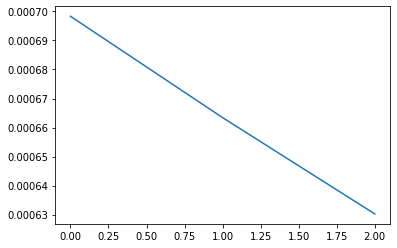

In [167]:
# Running fc_model
lrs = []
epochs = 3
print("[[ CNN model ]]")
for t in range(epochs):
  print(f"Epoch {t+1} =====================")
  lrs.append(cnn_optimizer.param_groups[0]['lr'])
  train_loop(train_dataloader, cnn_model, loss_fn, cnn_optimizer)
  test_loop(val_dataloader, cnn_model, loss_fn, data_name="Validate")
  cnn_scheduler.step()
plt.plot(lrs)
print("DONE!")

In [168]:
# Test test_dataset
test_loop(test_dataloader, cnn_model, loss_fn, data_name="Test")

[Test Error]
Accuracy: 98.9%, Avg loss: 0.06487482702497635



# Comparing our models (Linear based vs CNN based)

In [206]:
def test_func(dataloader, model1, model2):
  tot_X, tot_y, model1_y, model2_y = [], [], [], []
  for i, (X, y) in enumerate(dataloader):
    pred1 = model1(X)
    pred2 = model2(X)
    bool1 = (pred1.argmax(axis=1) == y)
    bool2 = (pred2.argmax(axis=1) != y)
    tot_bool = (bool1 * bool2)
    tot_X.append(X[tot_bool])
    tot_y.append(y[tot_bool])
    model1_y.append(pred1[tot_bool])
    model2_y.append(pred2[tot_bool])
  return torch.cat(tot_X), torch.cat(tot_y), torch.cat(model1_y), torch.cat(model2_y)

In [208]:
ret_X, ret_y, model1_y, model2_y = test_func(test_dataloader, cnn_model, fc_model)

In [209]:
ret_X.shape, ret_y.shape, model1_y.shape, model2_y.shape

(torch.Size([41, 1, 28, 28]),
 torch.Size([41]),
 torch.Size([41, 10]),
 torch.Size([41, 10]))

In [212]:
model1_y, model2_y = model1_y.argmax(axis=1), model2_y.argmax(axis=1)

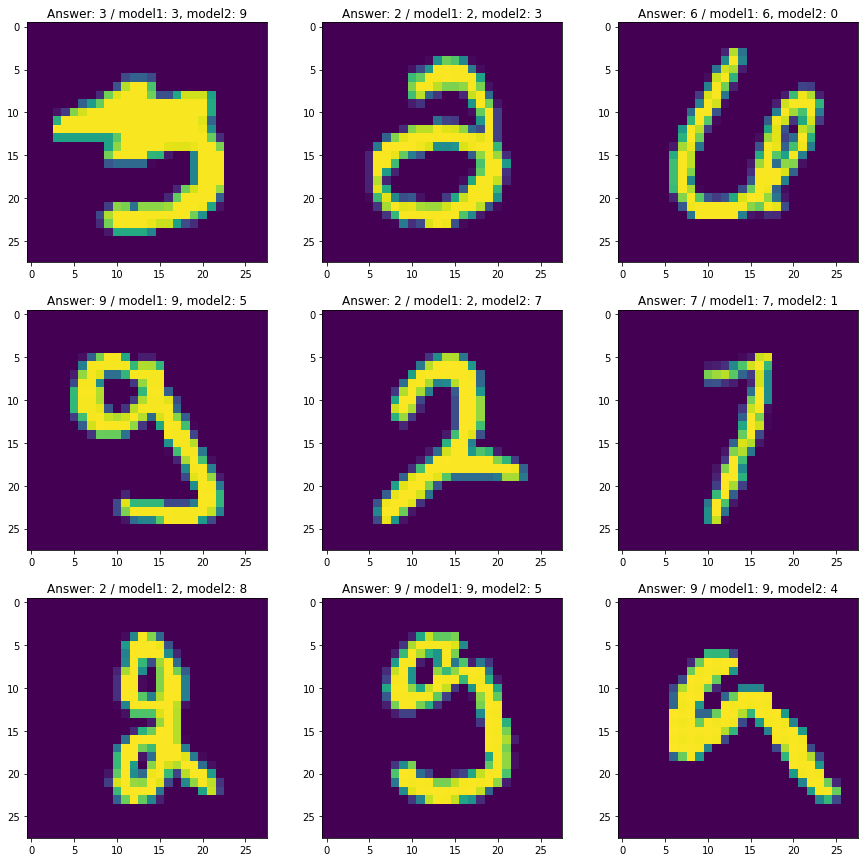

In [214]:
plt.figure(figsize=(15, 15))
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(ret_X[i].reshape(28, 28))
  plt.title(f"Answer: {ret_y[i].item()} / model1: {model1_y[i].item()}, model2: {model2_y[i].item()}")